# 2021-12-08 • Biology vs Izhikevich subthreshold

## [Prelude]

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga` on **Wed 19 Jan** 2022, at 02:40 (UTC+0000).<br>
[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/0fb11d4d81503d2e90e6a4bc907dff0fd0edabda
) (Tue 18 Jan 2022, 09:06).
Uncommited changes to 56 files.

## $dV/dt$

We reproduce dV curve from Badel 2008, fig 2 B.  
(fig 2 is for cortical neuron, fig 1 for something else).

EIF paremeters are taken from fig 2F, for time since last spike > 200 ms.

In [3]:
E_L = -57 * mV
τ_m = 17 * ms
V_rh = -42 * mV
Δ_T = 1.5 * mV
C = 200 * pF

dV_dt_EIF = lambda V, I: (E_L - V + Δ_T*np.exp((V - V_rh) / Δ_T)) / τ_m + I / C;

Fit Izhikevich neuron to Badel's EIF neuron: same resting potential, same spiking threshold.  
<!-- Parabola's curvature chosen by adapting $R k$ until slope at $E_L$ is the same. -->

In [4]:
from scipy.optimize import newton

In [5]:
V_t = newton(partial(dV_dt_EIF, I=0), -40*mV);

In [6]:
# Rk = 53

k = 0.7 * (nS / mV)

dV_dt_Izh = lambda V, I: (k * (V - E_L) * (V - V_t) + I) / C;

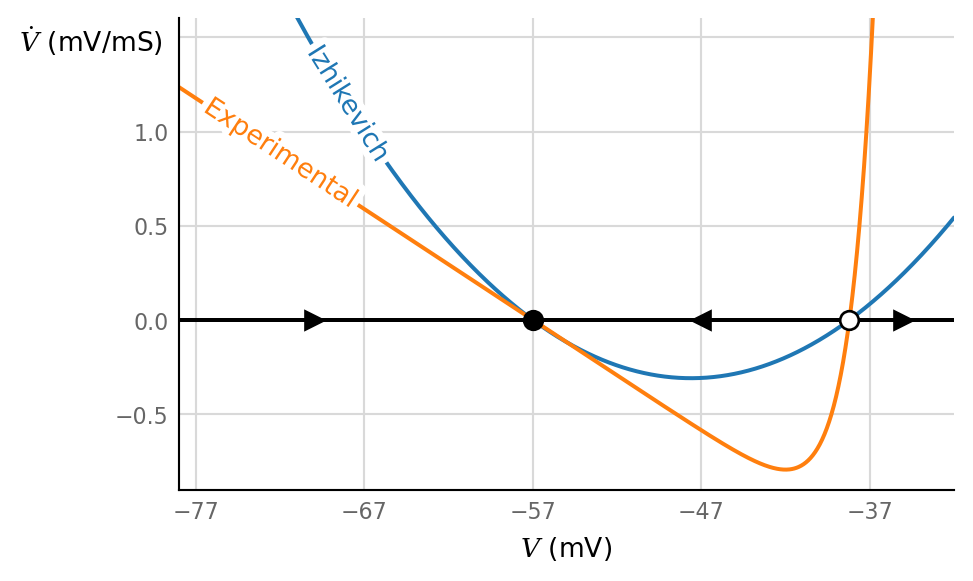

In [7]:
fig, ax = plt.subplots()
ax.axhline(y=0, color='k')
ax.set_xlabel("$V$ (mV)")
v.horizontal_ylabel(ax, "$\dot{V}$ (mV/mS)")
V = np.linspace(-78 * mV, -32 * mV, num=1000)
# V = np.linspace(E_L - 0.1*mV, E_L + 0.1*mV, num=1000)
ax.plot(V / mV, dV_dt_Izh(V, I=0), label="Izhikevich")
ax.plot(V / mV, dV_dt_EIF(V, I=0), label="Experimental")
ax.set_xticks(E_L/mV + np.array([-20, -10, 0, 10, 20]))
ax.plot(-70, 0, "k>", ms=7)
ax.plot(-47, 0, "k<", ms=7)
ax.plot(-35, 0, "k>", ms=7)
ax.plot(E_L/mV, 0, "ko", ms=7)
ax.plot(V_t/mV, 0, "ko", ms=7, markerfacecolor="white")
ax.set_xlim(-78, -32)
ax.set_ylim(-0.9, 1.6)
label_lines(ax.lines, xvals=[-68, -72]);

## Simulation

### Input

In [8]:
from voltage_to_wiring_sim.support.test_current import *

In [9]:
dt = 0.1 * ms
duration = 1700 * ms

timesteps = v.to_indices(duration, dt)

I = np.zeros(timesteps)

Q = 0.22 * nA * 10 * ms

T = 200*ms
τ=10*ms
add_δ(1.7*Q, (t_δ_up := 100*ms), I, dt)
add_δ(-1.7*Q, (t_δ_down := 200*ms), I, dt)
add_pulse_with_decay(Q, 300*ms, T, I, dt, τ)
add_pulse_with_decay(-Q, 450*ms, T, I, dt, τ)
add_pulse_with_decay(2*Q, 600*ms, T, I, dt, τ)
add_pulse_with_decay(-2*Q, 750*ms, T, I, dt, τ)
add_plateau(4*Q, 900*ms, T, I, dt)
add_ramp(4*Q, 1200*ms, T, I, dt)
add_pulse_with_decay(1.1*Q, 1500 * ms, T-100*ms, I, dt)
add_pulse_with_decay(1.1*Q, 1530 * ms, T-100*ms, I, dt)
add_pulse_with_decay(1.1*Q, 1560 * ms, T-100*ms, I, dt)

### Integration

In [10]:
V_EIF = np.ones(timesteps) * E_L
V_Izh = np.ones(timesteps) * E_L

for i in range(timesteps - 1):
    V_EIF[i+1] = V_EIF[i] + dV_dt_EIF(V_EIF[i], I[i]) * dt
    V_Izh[i+1] = V_Izh[i] + dV_dt_Izh(V_Izh[i], I[i]) * dt

### Plot

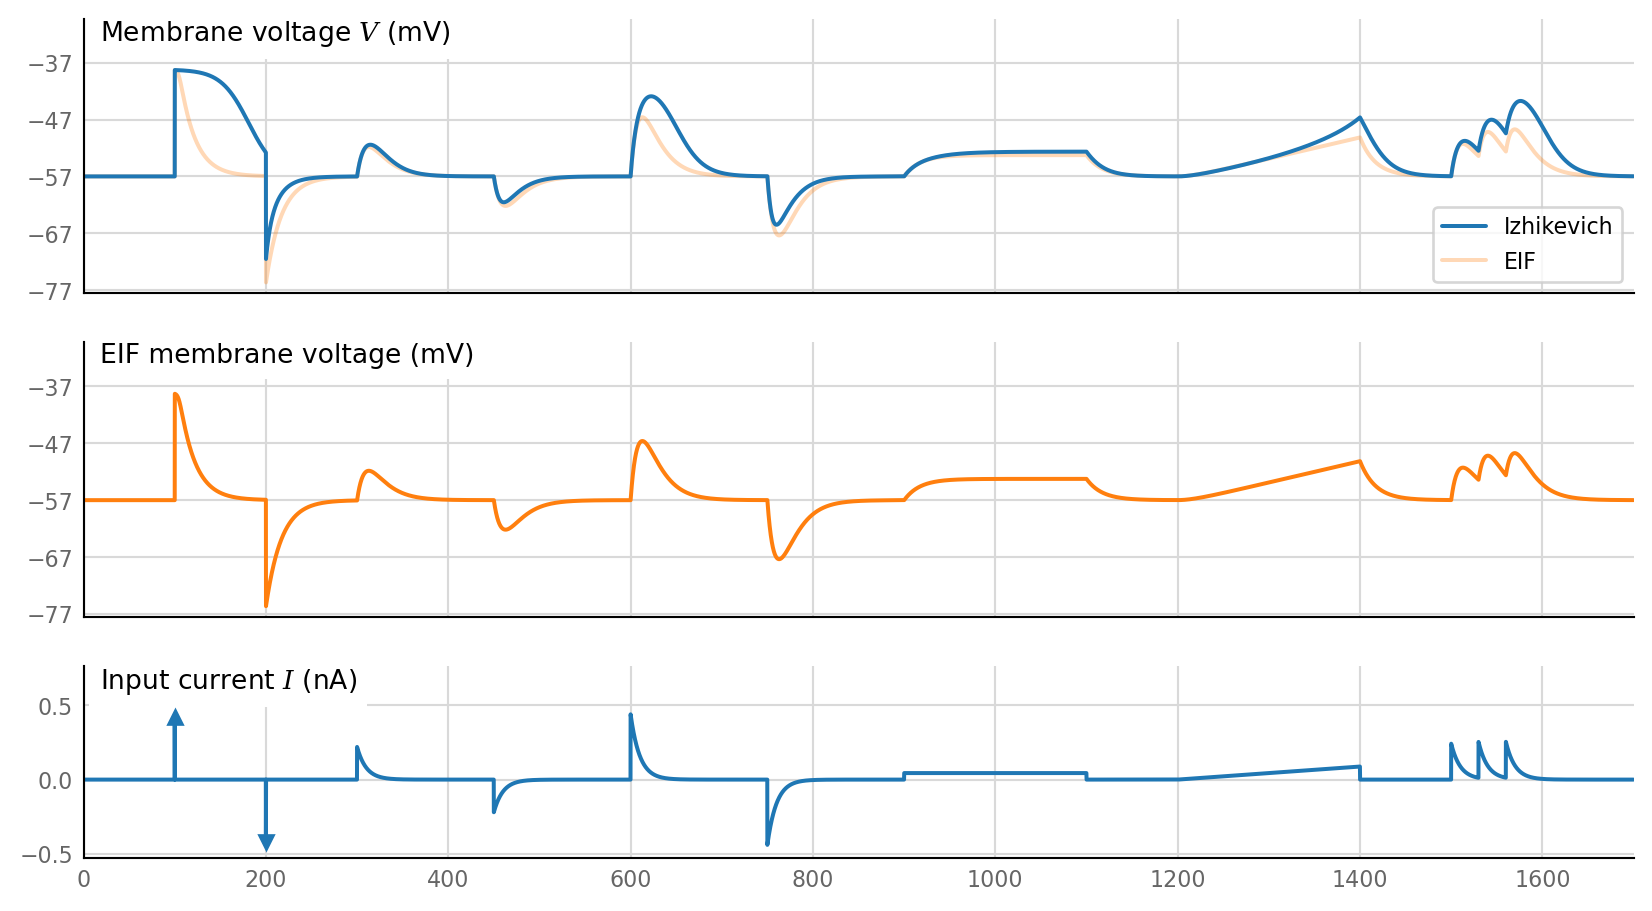

In [11]:
fig, axs = plt.subplots(nrows=3, sharex=True, **v.figsize(aspect=1.8, width=1000),
                         gridspec_kw=dict(height_ratios=[1, 1, 0.7]))

t = np.linspace(0, duration / ms, timesteps, False)
axs[1].plot(t, V_EIF / mV, c="C1")
axs[0].plot(t, V_EIF / mV, c="C1", alpha=0.3, label="EIF")
axs[0].plot(t, V_Izh / mV, c="C0", label="Izhikevich")
v.add_reordered_legend(axs[0], [1,0])
v.ylabel_inside(axs[0], "Membrane voltage $V$ (mV)", ylim_shift=18)
v.ylabel_inside(axs[1], "EIF membrane voltage (mV)", ylim_shift=18)
V_ticks = E_L / mV + np.arange(-20, 21, 10)
axs[0].set_yticks(V_ticks)
axs[1].set_yticks(V_ticks)
axs[1].set_ylim(axs[0].get_ylim())
plot_test_current(axs[2], t, I/nA, (-0.53, 0.53), yδ=0.8)
v.ylabel_inside(axs[2], "Input current $I$ (nA)", ylim_shift=16)
axs[0].set_xlim(left=0, right=duration/ms);

## [Reproducibility]

In [12]:
v.print_reproducibility_info(verbose=True) 

This cell was last run by `tfiers` on `yoga`<br>on **Wed 19 Jan** 2022, at 02:40 (UTC+0000).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/0fb11d4d81503d2e90e6a4bc907dff0fd0edabda
) (Tue 18 Jan 2022, 09:06).

Uncommited changes to:
```
M  .gitmodules
 D Manifest.toml
MM Project.toml
MM ReadMe.md
R  dev/Distributions -> codebase/julia/dev/Distributions
RD src/VoltageToMap.jl -> julia/src/VoltageToMap.jl
RD src/myplotlib/colors.jl -> julia/src/myplotlib/colors.jl
RD src/myplotlib/imports.jl -> julia/src/myplotlib/imports.jl
RD src/myplotlib/plot.jl -> julia/src/myplotlib/plot.jl
RD src/myplotlib/set.jl -> julia/src/myplotlib/set.jl
RD src/myplotlib/style.jl -> julia/src/myplotlib/style.jl
RD src/myplotlib/ticks.jl -> julia/src/myplotlib/ticks.jl
RD src/myplotlib/typecompat.jl -> julia/src/myplotlib/typecompat.jl
RD src/show.jl -> julia/src/show.jl
RD src/signal.jl -> julia/src/signal.jl
RD src/unitfuldistributions.jl -> julia/src/unitfuldistributions.jl
M  notebooks/2022-01-08__1000_to_1.ipynb
M  notebooks/2022-01-08__1000_to_1.jl
RD codebase/tests/test_run_embedded_tests.py -> python/tests/test_run_embedded_tests.py
RD codebase/voltage_to_wiring_sim/__init__.py -> python/voltage_to_wiring_sim/__init__.py
RD codebase/voltage_to_wiring_sim/conntest/STA.py -> python/voltage_to_wiring_sim/conntest/STA.py
RD codebase/voltage_to_wiring_sim/conntest/__init__.py -> python/voltage_to_wiring_sim/conntest/__init__.py
RD codebase/voltage_to_wiring_sim/conntest/classification.py -> python/voltage_to_wiring_sim/conntest/classification.py
RD codebase/voltage_to_wiring_sim/conntest/classification_IE.py -> python/voltage_to_wiring_sim/conntest/classification_IE.py
RD codebase/voltage_to_wiring_sim/conntest/permutation_test.py -> python/voltage_to_wiring_sim/conntest/permutation_test.py
RD codebase/voltage_to_wiring_sim/experiments/N_to_1.py -> python/voltage_to_wiring_sim/experiments/N_to_1.py
RD codebase/voltage_to_wiring_sim/experiments/N_to_1_IE.py -> python/voltage_to_wiring_sim/experiments/N_to_1_IE.py
RD codebase/voltage_to_wiring_sim/experiments/__init__.py -> python/voltage_to_wiring_sim/experiments/__init__.py
RD codebase/voltage_to_wiring_sim/notebook_init.py -> python/voltage_to_wiring_sim/notebook_init.py
RD codebase/voltage_to_wiring_sim/sim/__init__.py -> python/voltage_to_wiring_sim/sim/__init__.py
RD codebase/voltage_to_wiring_sim/sim/imaging.py -> python/voltage_to_wiring_sim/sim/imaging.py
RD codebase/voltage_to_wiring_sim/sim/izhikevich_neuron.py -> python/voltage_to_wiring_sim/sim/izhikevich_neuron.py
RD codebase/voltage_to_wiring_sim/sim/neuron_params.py -> python/voltage_to_wiring_sim/sim/neuron_params.py
RD codebase/voltage_to_wiring_sim/sim/poisson_spikes.py -> python/voltage_to_wiring_sim/sim/poisson_spikes.py
RD codebase/voltage_to_wiring_sim/sim/synapses.py -> python/voltage_to_wiring_sim/sim/synapses.py
RD codebase/voltage_to_wiring_sim/support/__init__.py -> python/voltage_to_wiring_sim/support/__init__.py
RD codebase/voltage_to_wiring_sim/support/array_wrapper.py -> python/voltage_to_wiring_sim/support/array_wrapper.py
RD codebase/voltage_to_wiring_sim/support/high_performance.py -> python/voltage_to_wiring_sim/support/high_performance.py
RD codebase/voltage_to_wiring_sim/support/misc.py -> python/voltage_to_wiring_sim/support/misc.py
RD codebase/voltage_to_wiring_sim/support/plot_style.py -> python/voltage_to_wiring_sim/support/plot_style.py
RD codebase/voltage_to_wiring_sim/support/plot_util.py -> python/voltage_to_wiring_sim/support/plot_util.py
RD codebase/voltage_to_wiring_sim/support/printing.py -> python/voltage_to_wiring_sim/support/printing.py
RD codebase/voltage_to_wiring_sim/support/reproducibility.py -> python/voltage_to_wiring_sim/support/reproducibility.py
RD codebase/voltage_to_wiring_sim/support/scalebar.py -> python/voltage_to_wiring_sim/support/scalebar.py
RD codebase/voltage_to_wiring_sim/support/signal.py -> python/voltage_to_wiring_sim/support/signal.py
RD codebase/voltage_to_wiring_sim/support/spike_train.py -> python/voltage_to_wiring_sim/support/spike_train.py
RD codebase/voltage_to_wiring_sim/support/test_current.py -> python/voltage_to_wiring_sim/support/test_current.py
RD codebase/voltage_to_wiring_sim/support/units.py -> python/voltage_to_wiring_sim/support/units.py
D  runtime.txt
 M setup.py
?? JuliaManifest.toml
?? JuliaProject.toml
?? codebase/julia/Manifest.toml
?? codebase/julia/Project.toml
?? codebase/julia/src/
?? codebase/python/
```

Platform:

Windows-10
CPython 3.9.7 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.21.4
matplotlib           3.4.3
numba                0.53.1
joblib               1.0.1
seaborn              0.11.1
scipy                1.7.2
preload              2.2
nptyping             1.4.0
matplotlib-label-lines 0.4.3


Full conda list:

```
# packages in environment at C:\conda:
#
# Name                    Version                   Build  Channel
anyio                     3.3.4            py39hcbf5309_1    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               21.1.0           py39hb82d6ee_2    conda-forge
async_generator           1.10                       py_0    conda-forge
atomicwrites              1.4.0              pyh9f0ad1d_0    conda-forge
attrs                     20.3.0             pyhd3deb0d_0    conda-forge
babel                     2.9.1              pyh44b312d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
black                     20.8b1                     py_1    conda-forge
bleach                    4.1.0              pyhd8ed1ab_0    conda-forge
bokeh                     2.4.1            py39hcbf5309_2    conda-forge
brian2                    2.5.0.1          py39h2e07f2f_0    conda-forge
brotlipy                  0.7.0           py39hb82d6ee_1003    conda-forge
bzip2                     1.0.8                h8ffe710_4    conda-forge
ca-certificates           2021.10.8            h5b45459_0    conda-forge
certifi                   2021.10.8        py39hcbf5309_1    conda-forge
cffi                      1.15.0           py39h0878f49_0    conda-forge
chardet                   4.0.0            py39hcbf5309_2    conda-forge
charset-normalizer        2.0.0              pyhd8ed1ab_0    conda-forge
click                     7.1.2              pyh9f0ad1d_0    conda-forge
cloudpickle               2.0.0              pyhd8ed1ab_0    conda-forge
colorama                  0.4.4              pyh9f0ad1d_0    conda-forge
conda                     4.11.0           py39hcbf5309_0    conda-forge
conda-package-handling    1.7.3            py39hb3671d1_1    conda-forge
console_shortcut          0.1.1                         4  
cryptography              35.0.0           py39h7bc7c5c_2    conda-forge
cycler                    0.11.0             pyhd8ed1ab_0    conda-forge
cython                    0.29.26          py39h415ef7b_0    conda-forge
cytoolz                   0.11.2           py39hb82d6ee_1    conda-forge
dask                      2021.1.0           pyhd8ed1ab_0    conda-forge
dask-core                 2021.1.0           pyhd8ed1ab_0    conda-forge
dataclasses               0.8                pyhc8e2a94_3    conda-forge
debugpy                   1.5.1            py39h415ef7b_0    conda-forge
decorator                 5.1.0              pyhd8ed1ab_0    conda-forge
defusedxml                0.7.1              pyhd8ed1ab_0    conda-forge
distributed               2021.1.1         py39hcbf5309_0    conda-forge
docutils                  0.16                     pypi_0    pypi
entrypoints               0.3             pyhd8ed1ab_1003    conda-forge
freetype                  2.10.4               h546665d_1    conda-forge
fsspec                    2021.11.0          pyhd8ed1ab_0    conda-forge
gitdb                     4.0.9              pyhd8ed1ab_0    conda-forge
gitpython                 3.1.24             pyhd8ed1ab_0    conda-forge
gsl                       2.7                  hdfb1a43_0    conda-forge
heapdict                  1.0.1                      py_0    conda-forge
icu                       68.2                 h0e60522_0    conda-forge
idna                      3.1                pyhd3deb0d_0    conda-forge
importlib-metadata        4.8.2            py39hcbf5309_0    conda-forge
importlib_metadata        4.8.2                hd3eb1b0_0  
importlib_resources       5.4.0              pyhd8ed1ab_0    conda-forge
iniconfig                 1.1.1              pyh9f0ad1d_0    conda-forge
intel-openmp              2021.4.0          h57928b3_3556    conda-forge
ipykernel                 6.5.0            py39h832f523_1    conda-forge
ipython                   7.29.0           py39h832f523_2    conda-forge
ipython_genutils          0.2.0                      py_1    conda-forge
ipywidgets                7.6.3              pyhd3deb0d_0    conda-forge
jbig                      2.1               h8d14728_2003    conda-forge
jedi                      0.18.0           py39hcbf5309_3    conda-forge
jinja2                    3.0.3              pyhd8ed1ab_0    conda-forge
joblib                    1.0.1                    pypi_0    pypi
jpeg                      9d                   h8ffe710_0    conda-forge
json5                     0.9.5              pyh9f0ad1d_0    conda-forge
jsonschema                4.2.1              pyhd8ed1ab_0    conda-forge
jupyter_client            7.0.6              pyhd8ed1ab_0    conda-forge
jupyter_contrib_core      0.3.3                      py_2    conda-forge
jupyter_contrib_nbextensions 0.5.1              pyhd8ed1ab_2    conda-forge
jupyter_core              4.9.1            py39hcbf5309_1    conda-forge
jupyter_highlight_selected_word 0.2.0           py39hcbf5309_1002    conda-forge
jupyter_latex_envs        1.4.6           pyhd8ed1ab_1002    conda-forge
jupyter_nbextensions_configurator 0.4.1            py39hcbf5309_2    conda-forge
jupyter_server            1.11.2             pyhd8ed1ab_0    conda-forge
jupyterlab                3.0.5              pyhd8ed1ab_0    conda-forge
jupyterlab-classic        0.1.3              pyhd8ed1ab_0    conda-forge
jupyterlab-sublime        0.4.1                    pypi_0    pypi
jupyterlab_pygments       0.1.2              pyh9f0ad1d_0    conda-forge
jupyterlab_server         2.8.2              pyhd8ed1ab_0    conda-forge
jupyterlab_widgets        1.0.2              pyhd8ed1ab_0    conda-forge
jupytext                  1.10.0             pyh44b312d_0    conda-forge
jupytray                  0.7.post10+dirty           dev_0    <develop>
keyring                   21.8.0                   pypi_0    pypi
kiwisolver                1.3.2            py39h2e07f2f_1    conda-forge
krb5                      1.19.2               h20d022d_3    conda-forge
lcms2                     2.12                 h2a16943_0    conda-forge
lerc                      3.0                  h0e60522_0    conda-forge
libarchive                3.5.2                hb45042f_1    conda-forge
libblas                   3.9.0                     8_mkl    conda-forge
libcblas                  3.9.0                     8_mkl    conda-forge
libclang                  11.1.0          default_h5c34c98_1    conda-forge
libcurl                   7.80.0               h789b8ee_0    conda-forge
libdeflate                1.8                  h8ffe710_0    conda-forge
libiconv                  1.16                 he774522_0    conda-forge
liblapack                 3.9.0                     8_mkl    conda-forge
libpng                    1.6.37               h1d00b33_2    conda-forge
libsodium                 1.0.18               h8d14728_1    conda-forge
libsolv                   0.7.19               h7755175_5    conda-forge
libssh2                   1.10.0               h680486a_2    conda-forge
libtiff                   4.3.0                hd413186_2    conda-forge
libxml2                   2.9.12               hf5bbc77_1    conda-forge
libxslt                   1.1.33               h65864e5_3    conda-forge
libzlib                   1.2.11            h8ffe710_1013    conda-forge
llvmlite                  0.36.0           py39ha0cd8c8_0    conda-forge
locket                    0.2.0                      py_2    conda-forge
lxml                      4.6.4            py39h4fd7cdf_0    conda-forge
lz4-c                     1.9.3                h8ffe710_1    conda-forge
lzo                       2.10              he774522_1000    conda-forge
m2w64-gcc-libgfortran     5.3.0                         6    conda-forge
m2w64-gcc-libs            5.3.0                         7    conda-forge
m2w64-gcc-libs-core       5.3.0                         7    conda-forge
m2w64-gmp                 6.1.0                         2    conda-forge
m2w64-libwinpthread-git   5.0.0.4634.697f757               2    conda-forge
mamba                     0.7.14           py39h006a82b_0    conda-forge
markdown-it-py            0.6.2              pyhd8ed1ab_0    conda-forge
markdown2                 2.4.0                    pypi_0    pypi
markupsafe                2.0.1            py39hb82d6ee_1    conda-forge
matplotlib-base           3.4.3            py39h581301d_2    conda-forge
matplotlib-inline         0.1.3              pyhd8ed1ab_0    conda-forge
matplotlib-label-lines    0.4.3                    pypi_0    pypi
mdit-py-plugins           0.2.5              pyhd8ed1ab_0    conda-forge
menuinst                  1.4.18           py39hcbf5309_1    conda-forge
mistune                   0.8.4           py39hb82d6ee_1005    conda-forge
mkl                       2020.4             hb70f87d_311    conda-forge
more-itertools            8.11.0             pyhd8ed1ab_0    conda-forge
mpmath                    1.2.1              pyhd8ed1ab_0    conda-forge
msgpack-python            1.0.2            py39h2e07f2f_2    conda-forge
msys2-conda-epoch         20160418                      1    conda-forge
multipledispatch          0.6.0                    pypi_0    pypi
multitasking              0.0.9                    pypi_0    pypi
mypy_extensions           0.4.3            py39hcbf5309_4    conda-forge
nb_conda_kernels          2.3.1            py39hcbf5309_1    conda-forge
nbclassic                 0.2.6              pyhd8ed1ab_0    conda-forge
nbclient                  0.5.8              pyhd8ed1ab_0    conda-forge
nbconvert                 6.3.0            py39hcbf5309_1    conda-forge
nbdime                    2.1.0                      py_0    conda-forge
nbformat                  5.0.8                      py_0    conda-forge
nest-asyncio              1.5.1              pyhd8ed1ab_0    conda-forge
notebook                  6.4.5              pyha770c72_0    conda-forge
nptyping                  1.4.0                    pypi_0    pypi
numba                     0.53.1           py39hb8cd55e_1    conda-forge
numpy                     1.21.4           py39h6635163_0    conda-forge
oauthlib                  3.1.0                    pypi_0    pypi
oboe                      0.2                      pypi_0    pypi
olefile                   0.46               pyh9f0ad1d_1    conda-forge
openjpeg                  2.4.0                hb211442_1    conda-forge
openssl                   1.1.1l               h8ffe710_0    conda-forge
packaging                 21.2               pyhd8ed1ab_1    conda-forge
pandas                    1.3.4            py39h2e25243_1    conda-forge
pandoc                    2.16.1               h8ffe710_0    conda-forge
pandocfilters             1.5.0              pyhd8ed1ab_0    conda-forge
parso                     0.8.2              pyhd8ed1ab_0    conda-forge
partd                     1.2.0              pyhd8ed1ab_0    conda-forge
pathspec                  0.9.0              pyhd8ed1ab_0    conda-forge
patsy                     0.5.2              pyhd8ed1ab_0    conda-forge
pickleshare               0.7.5                   py_1003    conda-forge
pillow                    8.4.0            py39h916092e_0    conda-forge
pint                      0.18               pyhd8ed1ab_0    conda-forge
pip                       21.3.1             pyhd8ed1ab_0    conda-forge
pkginfo                   1.6.1                    pypi_0    pypi
pluggy                    1.0.0            py39hcbf5309_2    conda-forge
powershell_shortcut       0.0.1                         3  
preload                   2.2                      pypi_0    pypi
prometheus_client         0.12.0             pyhd8ed1ab_0    conda-forge
prompt-toolkit            3.0.22             pyha770c72_0    conda-forge
psutil                    5.8.0            py39hb82d6ee_2    conda-forge
py                        1.11.0             pyh6c4a22f_0    conda-forge
py-cpuinfo                8.0.0              pyhd8ed1ab_0    conda-forge
pycosat                   0.6.3           py39hb82d6ee_1009    conda-forge
pycparser                 2.21               pyhd8ed1ab_0    conda-forge
pygments                  2.10.0             pyhd8ed1ab_0    conda-forge
pyopenssl                 21.0.0             pyhd8ed1ab_0    conda-forge
pypandoc                  1.6.3                    pypi_0    pypi
pyparsing                 2.4.7              pyhd8ed1ab_1    conda-forge
pyqt                      5.12.3           py39hb0d2dfa_4    conda-forge
pyqt5-sip                 4.19.18                  pypi_0    pypi
pyqtchart                 5.12                     pypi_0    pypi
pyqtwebengine             5.12.1                   pypi_0    pypi
pyrsistent                0.18.0           py39hb82d6ee_0    conda-forge
pysocks                   1.7.1            py39hcbf5309_4    conda-forge
pytest                    6.2.5            py39hcbf5309_1    conda-forge
python                    3.9.7           h7840368_3_cpython    conda-forge
python-dateutil           2.8.2              pyhd8ed1ab_0    conda-forge
python_abi                3.9                      2_cp39    conda-forge
pytz                      2021.3             pyhd8ed1ab_0    conda-forge
pywin32                   302              py39hb82d6ee_2    conda-forge
pywin32-ctypes            0.2.0                    pypi_0    pypi
pywinpty                  1.1.6            py39h99910a6_0    conda-forge
pyyaml                    6.0              py39hb82d6ee_3    conda-forge
pyzmq                     22.3.0           py39he46f08e_1    conda-forge
qt                        5.12.9               h5909a2a_4    conda-forge
readme-renderer           28.0                     pypi_0    pypi
regex                     2021.11.10       py39hb82d6ee_0    conda-forge
reproc                    14.2.3               h8ffe710_0    conda-forge
reproc-cpp                14.2.3               h0e60522_0    conda-forge
requests                  2.26.0             pyhd8ed1ab_0    conda-forge
requests-oauthlib         1.3.0                    pypi_0    pypi
requests-toolbelt         0.9.1                    pypi_0    pypi
rfc3986                   1.4.0                    pypi_0    pypi
ruamel_yaml               0.15.80         py39hb82d6ee_1006    conda-forge
scikit-learn              1.0.1            py39he931e04_2    conda-forge
scipy                     1.7.2            py39hc0c34ad_0    conda-forge
seaborn                   0.11.1               h57928b3_0    conda-forge
seaborn-base              0.11.1             pyhd8ed1ab_1    conda-forge
send2trash                1.8.0              pyhd8ed1ab_0    conda-forge
setuptools                59.1.1           py39hcbf5309_0    conda-forge
setuptools-scm            5.0.1                    pypi_0    pypi
six                       1.16.0             pyh6c4a22f_0    conda-forge
smmap                     3.0.5              pyh44b312d_0    conda-forge
snakeviz                  2.1.0              pyh9f0ad1d_0    conda-forge
sniffio                   1.2.0            py39hcbf5309_2    conda-forge
sortedcontainers          2.4.0              pyhd8ed1ab_0    conda-forge
sqlite                    3.36.0               h8ffe710_2    conda-forge
statsmodels               0.13.1           py39h5d4886f_0    conda-forge
sympy                     1.9              py39hcbf5309_1    conda-forge
tblib                     1.7.0              pyhd8ed1ab_0    conda-forge
terminado                 0.12.1           py39hcbf5309_1    conda-forge
testpath                  0.5.0              pyhd8ed1ab_0    conda-forge
tfiers                    0.3.2                     dev_0    <develop>
threadpoolctl             3.0.0              pyh8a188c0_0    conda-forge
tk                        8.6.11               h8ffe710_1    conda-forge
toml                      0.10.2             pyhd8ed1ab_0    conda-forge
toolz                     0.11.2             pyhd8ed1ab_0    conda-forge
tornado                   6.1              py39hb82d6ee_2    conda-forge
tqdm                      4.62.3             pyhd8ed1ab_0    conda-forge
traitlets                 5.1.1              pyhd8ed1ab_0    conda-forge
tweepy                    3.10.0                   pypi_0    pypi
twine                     3.3.0                    pypi_0    pypi
typed-ast                 1.5.0            py39hb82d6ee_0    conda-forge
typing_extensions         3.10.0.2           pyha770c72_0    conda-forge
typish                    1.9.1                    pypi_0    pypi
tzdata                    2021e                he74cb21_0    conda-forge
ucrt                      10.0.20348.0         h57928b3_0    conda-forge
unitlib                   0.3                      pypi_0    pypi
unyt                      2.8.0                      py_0    conda-forge
urllib3                   1.26.7             pyhd8ed1ab_0    conda-forge
vc                        14.2                 hb210afc_5    conda-forge
voltage-to-wiring-sim     0.1                       dev_0    <develop>
vs2015_runtime            14.29.30037          h902a5da_5    conda-forge
wcwidth                   0.2.5              pyh9f0ad1d_2    conda-forge
webencodings              0.5.1                      py_1    conda-forge
websocket-client          1.2.1            py39hcbf5309_0    conda-forge
wheel                     0.37.0             pyhd8ed1ab_1    conda-forge
widgetsnbextension        3.5.2            py39hcbf5309_0    conda-forge
win_inet_pton             1.1.0            py39hcbf5309_3    conda-forge
windows-curses            2.2.0                    pypi_0    pypi
winpty                    0.4.3                         4    conda-forge
winshell                  0.6                      pypi_0    pypi
xz                        5.2.5                h62dcd97_1    conda-forge
yaml                      0.2.5                he774522_0    conda-forge
yfinance                  0.1.55                   pypi_0    pypi
zeromq                    4.3.4                h0e60522_1    conda-forge
zict                      2.0.0                      py_0    conda-forge
zipp                      3.6.0              pyhd8ed1ab_0    conda-forge
zlib                      1.2.11            h8ffe710_1013    conda-forge
zstd                      1.5.0                h6255e5f_0    conda-forge
```